# Import Packages

In [58]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
%matplotlib inline
import seaborn as sns

from functools import reduce

import datetime as dt

import missingno as msno # viz missing values

sns.set_style("darkgrid")
import itertools

# show all the rows
pd.set_option('display.max_rows', 500)

# Read Datasets

In [62]:
Transactions = pd.read_excel('Transactions.xlsx')

In [63]:
label_2 = pd.read_excel('label_2.xlsx')

In [64]:
label_3 = pd.read_excel('label_3.xlsx')

# Transfer Transaction table

In [65]:
Transactions.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,140,11,462,2017-01-01,0,Approved,Giant Bicycles,Standard,high,medium,1274.93,764.96,2016-07-11
1,517,77,311,2017-01-01,1,Approved,WeareA2B,Standard,medium,medium,1769.64,108.76,2011-05-11
2,561,65,2298,2017-01-01,0,Approved,WeareA2B,Standard,medium,medium,1807.45,778.69,2010-08-22
3,1293,67,1931,2017-01-01,1,Approved,Norco Bicycles,Road,medium,medium,544.05,376.84,2005-10-24
4,1403,0,2891,2017-01-01,1,Approved,OHM Cycles,Standard,medium,medium,183.86,137.90,1993-07-22


<AxesSubplot:xlabel='order_status', ylabel='Count'>

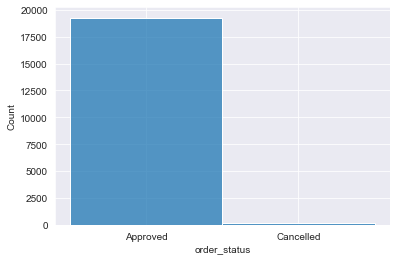

In [66]:
sns.histplot(data=Transactions, x = 'order_status')

## 1. Remove transactions which were cancelled

In [67]:
Transactions = Transactions[Transactions['order_status'] == 'Approved']

In [68]:
#sns.histplot(data=Transactions, x = 'brand')

In [69]:
#sns.histplot(data=Transactions, x = 'product_line')

In [70]:
#sns.histplot(data=Transactions, x = 'product_class')

In [71]:
#sns.histplot(data=Transactions, x = 'product_size')

## 2. New or old product?

In [72]:
Transactions['product_year'] = Transactions['product_first_sold_date'].apply(lambda x: (pd.to_datetime('2017-12-31').year - x.year))

<AxesSubplot:xlabel='product_year', ylabel='Count'>

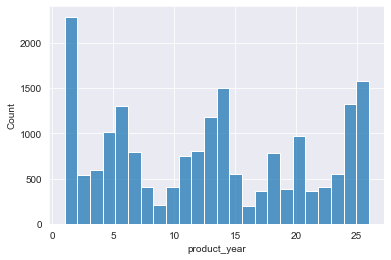

In [73]:
sns.histplot(data=Transactions, x = 'product_year')

*But how to define new or old product?*

*relationship between product age and price?*

<AxesSubplot:xlabel='product_year', ylabel='ave_price'>

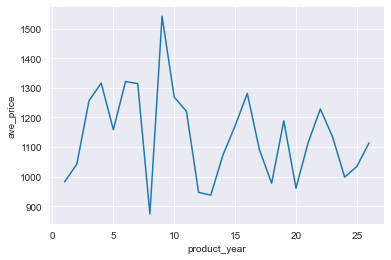

In [74]:
temp = Transactions.groupby(['product_year'])['list_price'].mean().to_frame(name='ave_price').reset_index()
sns.lineplot(x='product_year', y='ave_price', data=temp)

**Conclusion: there is no obvious correlation between  product age and product price**

**definition:**
- the product is released in 10 years --> new product
- the product is released 10 years ago or even earlier --> old product

In [75]:
Transactions['product_age'] = Transactions['product_year'].apply(lambda x: 'new' if x <= 10 else 'old')

In [76]:
Transactions.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date,product_year,product_age
0,140,11,462,2017-01-01,0,Approved,Giant Bicycles,Standard,high,medium,1274.93,764.96,2016-07-11,1,new
1,517,77,311,2017-01-01,1,Approved,WeareA2B,Standard,medium,medium,1769.64,108.76,2011-05-11,6,new
2,561,65,2298,2017-01-01,0,Approved,WeareA2B,Standard,medium,medium,1807.45,778.69,2010-08-22,7,new
3,1293,67,1931,2017-01-01,1,Approved,Norco Bicycles,Road,medium,medium,544.05,376.84,2005-10-24,12,old
4,1403,0,2891,2017-01-01,1,Approved,OHM Cycles,Standard,medium,medium,183.86,137.90,1993-07-22,24,old


<AxesSubplot:xlabel='product_age', ylabel='Count'>

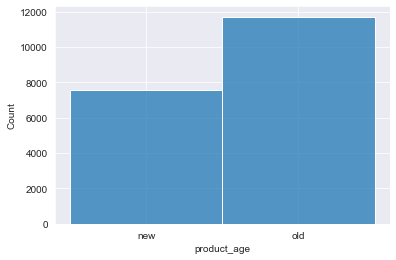

In [77]:
sns.histplot(data=Transactions, x = 'product_age')

## 3. Transaction data --> month

In [78]:
Transactions['trans_month'] = Transactions['transaction_date'].apply(lambda x: (pd.to_datetime(x).month))

<AxesSubplot:xlabel='trans_month', ylabel='Count'>

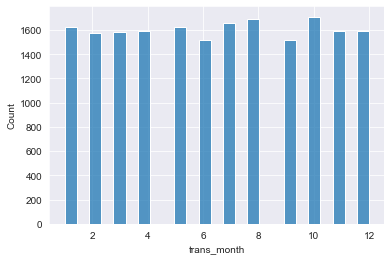

In [79]:
sns.histplot(data=Transactions, x = 'trans_month')

**this is a demo**

| customer_id | product_age |
| -- | -- |
| 01 | old |
| 01 | old |
| 01 | new |
| 02 | new |
| 02 |  new|

| customer_id | product_age_old | product_age_new |
| -- | -- | -- |
| 01 | 2 | 1 |
| 02 | 0 | 2 |

refer to this [webpage](https://www.statology.org/pandas-merge-multiple-dataframes/)

# Transfer data cut (The first M months transactions)

In [80]:
month = ['2017-01-31', 
         '2017-02-28', 
         '2017-03-31', 
         '2017-04-30', 
         '2017-05-31', 
         '2017-06-30', 
         '2017-07-31', 
         '2017-08-31', 
         '2017-09-30', 
         '2017-10-31', 
         '2017-11-30',
         '2017-12-30']

In [81]:
for i in range(len(month)):
    Transactions_cut = Transactions[Transactions['transaction_date'] <= month[i]]
    print(f'by the end of {month[i]}')
    print(f'dataset shape is {Transactions_cut.shape}')
    
    # product_age
    temp1 = pd.crosstab(Transactions_cut['customer_id'], Transactions_cut['product_age']).reset_index().rename_axis(columns = None)
    temp1.rename(columns={'new':'product_age_new', 'old':'product_age_old'}, inplace=True)
    
    # brand
    temp2 = pd.crosstab(Transactions_cut['customer_id'], Transactions_cut['brand']).reset_index().rename_axis(columns = None)
    
    # product_line
    temp3 = pd.crosstab(Transactions_cut['customer_id'], Transactions_cut['product_line']).reset_index().rename_axis(columns = None)
    
    # product_class
    temp4 = pd.crosstab(Transactions_cut['customer_id'], Transactions_cut['product_class']).reset_index().rename_axis(columns = None)
    temp4.rename(columns={'high':'product_class_high', 
                          'low':'product_class_low',
                          'medium':'product_class_medium'}, inplace=True)
    
    # product_size
    temp5 = pd.crosstab(Transactions_cut['customer_id'], Transactions_cut['product_size']).reset_index().rename_axis(columns = None)
    temp5.rename(columns={'large':'product_size_large', 
                          'medium':'product_size_medium',
                          'small':'product_size_small'}, inplace=True)
    
    # multi_trans
    # some customers made multiple transactions on the same day
    temp = Transactions_cut.groupby(['customer_id', 'transaction_date'])['transaction_id'].count().to_frame(name='cnt').reset_index()

    # get list of customers who have multiple transactions on the same day
    lst = temp[temp['cnt'] > 1]['customer_id'].to_list()

    Transactions_cut['multi_trans'] = Transactions_cut['customer_id'].apply(lambda x: 1 if x in lst else 0)
    temp6 = Transactions_cut[['customer_id','multi_trans']].drop_duplicates(subset = ["customer_id"]).sort_values(by=['customer_id']).reset_index().drop('index', axis=1)
    
    # define a list of dataframes
    dfs = [temp1, temp2, temp3, temp4, temp5, temp6]
    
    # merge all dataframes into one
    df = reduce(lambda left,right: pd.merge(left,right,on=['customer_id'], how='outer'), dfs)
    
    PastCust_trans_cut_fm_labeled_2 = df.merge(label_2, on = 'customer_id', how='inner')
    
    # export file
    file_name ='PastCust_trans_cut_first' + '_' + str(i+1) + '_' + 'months_labeled_2.xlsx'
    PastCust_trans_cut_fm_labeled_2.to_excel(file_name, index=False)

by the end of 2017-01-31
dataset shape is (1621, 16)
by the end of 2017-02-28
dataset shape is (3194, 16)
by the end of 2017-03-31
dataset shape is (4779, 16)
by the end of 2017-04-30
dataset shape is (6375, 16)
by the end of 2017-05-31
dataset shape is (7999, 16)
by the end of 2017-06-30
dataset shape is (9517, 16)
by the end of 2017-07-31
dataset shape is (11173, 16)
by the end of 2017-08-31
dataset shape is (12860, 16)
by the end of 2017-09-30
dataset shape is (14380, 16)
by the end of 2017-10-31
dataset shape is (16090, 16)
by the end of 2017-11-30
dataset shape is (17682, 16)
by the end of 2017-12-30
dataset shape is (19273, 16)
